In [51]:
from sklearn.kernel_ridge import KernelRidge
from sklearn import preprocessing
#from sklearn.model_selection import GridSearchCV
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
import random
#color = sns.color_palette()

%matplotlib inline


In [124]:
train_data = pd.read_csv('train.data.csv')
test_data = pd.read_csv('test.data.csv')
train_data.columns

Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [53]:
train_data.head(5)

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,4,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,5,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,6,7237550310,20140512T000000,1225000,4,4.50,5420,101930,1.0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
4,7,1321400060,20140627T000000,257500,3,2.25,1715,6819,2.0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819


In [54]:
# a quick overview of training data
print('train data size:',train_data.shape)
print('test data size:',test_data.shape)
print('train data attribute: ')
train_data.dtypes

train data size: (15129, 22)
test data size: (6484, 22)
train data attribute: 


Unnamed: 0         int64
id                 int64
date              object
price              int64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

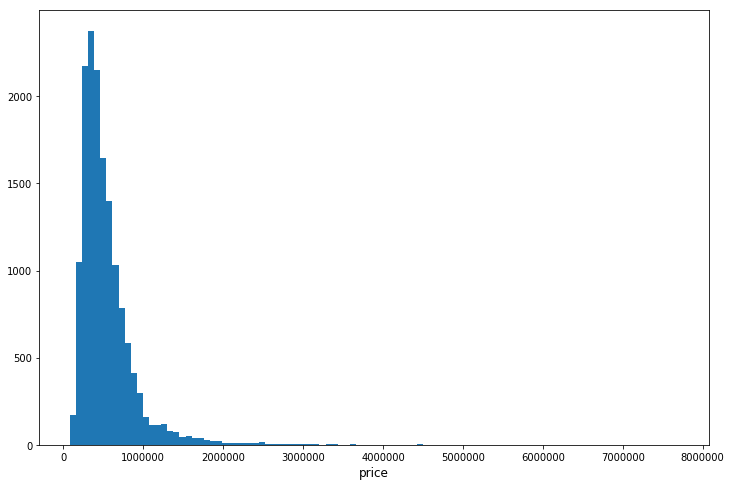

In [5]:
# a quick view on the price distribution
plt.figure(figsize=(12,8))
plt.hist(train_data.price, bins=100)
plt.xlabel('price', fontsize=12)
plt.show()

In [125]:
# construct training set data and testing set data
debug_flag = False
if debug_flag:
    train_size = 3000
else:
    train_size = train_data.shape[0]
random.seed(0)
train_idx = random.sample(list(train_data.index), train_size)


X_train = train_data.loc[:, ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot']]
## add a zipcode factor variable
#X_train = pd.merge(left=X_train, right=zipcodes_cat, on =X_train.index).drop(columns='key_0')
Y_train = train_data.price

if debug_flag:
    X_train = X_train.iloc[train_idx,:]
    Y_train = Y_train.iloc[train_idx]

print(X_train.shape)
print("training price variance:", Y_train.std())


X_test = test_data.loc[:, ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot']]
## add a zipcode factor varaible
#X_test = pd.merge(left=X_test, right= pd.get_dummies(test_data.zipcode), on=X_test.index).drop(columns='key_0')
Y_test = test_data.price
print(X_test.shape)
print("testing price variance:", Y_test.std())




(15129, 4)
training price variance: 367448.95708729426
(6484, 4)
testing price variance: 366363.6387748185


In [126]:
###############################
# standardize the train and testing data
###############################

def rescale(X,Y):
    names = X.columns
    scaler = preprocessing.StandardScaler()
    scaled_matrix = scaler.fit_transform(X.astype('float64'))
    X =pd.DataFrame(scaled_matrix, columns=names)
    Y = (Y- Y.mean() ) / Y.std()
    
    return (X,Y)

X_train, Y_train = rescale(X_train, Y_train)
X_test, Y_test = rescale(X_test, Y_test)


In [127]:
############################################
# linear regression with ridge penalty
############################################
from sklearn.linear_model import Ridge

alpha = 0.5

#clf = KernelRidge(kernel='linear', alpha=alpha)
clf = Ridge(alpha = alpha)

# regression
t0 = time.time()
clf.fit(X_train, Y_train)
print("linear ridge complexity and bandwidth selected and model fitted in %.3f s"
      % (time.time() - t0))

# prediction
pred = clf.predict(X_test)
print('pred:', pred)

# R2
print('R2:',clf.score(X_test, Y_test))


linear ridge complexity and bandwidth selected and model fitted in 0.003 s
pred: [-0.73530074 -0.92691272  1.33027271 ... -0.45319615  0.2697437
  1.13330261]
R2: 0.5052600356531718


In [128]:
################################
# Gaussian kernel ridge regression 
# alpha: ridge coefficient
# gamma: kernel bandwidth
###################################
alpha = 0.5
gamma = 0.01/2
krr = KernelRidge(kernel='rbf', gamma=gamma, alpha = alpha)

# kernel ridge regression    
t0 = time.time()
krr.fit(X_train, Y_train)
krr_fit_time = time.time() - t0
print("KRR complexity and bandwidth selected and model fitted in %.3f s"
      % krr_fit_time)

# prediction
t0 = time.time()
pred_kr = krr.predict(X_test)
print("Time for KRR prediction: %.3f" % (time.time() - t0))
print('pred:',pred_kr)

# out of sample R2
r2 = krr.score(X_test, Y_test)
print('R2:', r2)

KRR complexity and bandwidth selected and model fitted in 52.522 s
Time for KRR prediction: 4.743
pred: [-0.54035436 -0.63587946  1.19290105 ... -0.43955667  0.14395226
  1.24548971]
R2: 0.5496907405954307


In [92]:
# cross validation
from sklearn.model_selection import cross_val_score

alpha = 0.5
gamma = 0.01/2
krr = KernelRidge(kernel='rbf', gamma=gamma, alpha = alpha)

n_folds = 5
t0 = time.time()
score = cross_val_score(krr, X_train, Y_train , cv=n_folds)
print("Time for cross validation: %.3f s" % (time.time()-t0) )
score


Time for cross validation: 138.706 s


array([0.57447585, 0.57572011, 0.55999529, 0.53551842, 0.56342402])

In [86]:
# cross validation to choose lambda
########################
# around 20 mins
##########################
run_cv_flag =False

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

alphas = np.logspace(-4, 1, 10)
tuned_parameters = { 'gamma': [0.01/2],
                     'alpha': alphas}
n_folds = 5
scoring = {'R2': 'r2',
           'mse': make_scorer(mean_squared_error, greater_is_better = False)}

krr = KernelRidge(kernel='rbf')

if run_cv_flag:
    clf = GridSearchCV(estimator = krr, 
                        param_grid = tuned_parameters, cv=n_folds, 
                        scoring = scoring, refit=False, return_train_score=True )

    train_size = X_train.shape[0]
    clf.fit(X_train.loc[:train_size,], Y_train.loc[:train_size,])
    results= clf.cv_results_
    
print(results['mean_test_%s' % 'mse'])
print(results['mean_test_%s' % 'R2'])




/home/carrie/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


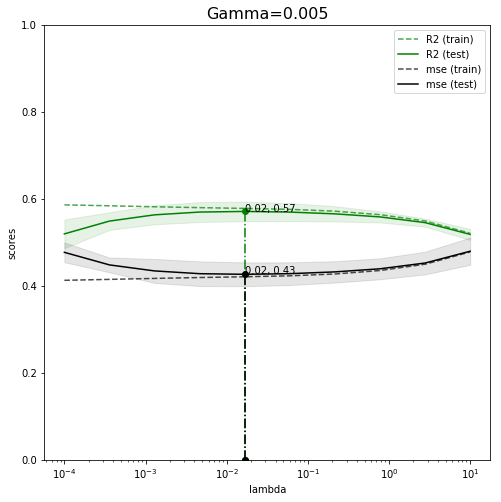

In [147]:
param_string = "alpha"

plt.figure(figsize=(8, 8))
plt.title("Gamma=%s"% (0.01/2), fontsize=16)

plt.xlabel('lambda')
plt.ylabel("scores")
ax = plt.gca()
ax.set_ylim(0, 1)
#ax.set_yscale('log')
ax.set_xscale('log')
X_axis = np.array(results['param_%s' % param_string].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        if (scorer == 'mse'):
            sample_score_mean = sample_score_mean * (-1)
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]
    if (scorer == 'mse'):
        best_score = best_score * (-1)

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='.', markeredgewidth=3, ms=8)
    # Annotate the best score for that scorer
    ax.annotate("%.2f, %0.2f" % (X_axis[best_index], best_score),
                (X_axis[best_index], best_score))


plt.legend(loc="best")
plt.grid('off')
plt.show()


In [129]:
##################################################
# regression using all dependecy variables
#################################################
def rescale(X,Y):
    names = X.columns
    scaler = preprocessing.StandardScaler()
    scaled_matrix = scaler.fit_transform(X.astype('float64'))
    X =pd.DataFrame(scaled_matrix, columns=names)
    Y = (Y- Y.mean() ) / Y.std()
    
    return (X,Y)

debug_flag = False
if debug_flag:
    train_size = 3000
else:
    train_size = train_data.shape[0]
random.seed(0)
train_idx = random.sample(list(train_data.index), train_size)

## covert zipcodes to factor variables
zipcodes_cat= pd.get_dummies(train_data.zipcode)
print('number of zipcodes:', len(train_data.zipcode.unique()))


# train data
X_train = train_data.drop(columns=['Unnamed: 0','id','date','price'])
Y_train = train_data.price
# rescale train data
X_train, Y_train = rescale(X_train, Y_train)
# attach zipcode dummy variables
X_train = pd.merge(left=X_train.drop(columns=['zipcode']), 
                   right=pd.get_dummies(train_data.zipcode), on=X_train.index).drop(columns='key_0')

if debug_flag:
    X_train = X_train.iloc[train_idx,:]
    Y_train = Y_train.iloc[train_idx]
print(X_train.shape)


# test data
X_test = test_data.drop(columns=['Unnamed: 0','id','date','price'])
Y_test = test_data.price
# rescale test data
X_test, Y_test = rescale(X_test, Y_test)
# attach zipcode dummy variable
X_test = pd.merge(left=X_test.drop(columns=['zipcode']),
                  right=pd.get_dummies(test_data.zipcode),on=X_test.index).drop(columns='key_0')

print(X_test.shape)

X_train.head()

number of zipcodes: 70
(15129, 87)
(6484, 87)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,-0.389789,0.184786,0.544670,-0.191753,0.943982,-0.086361,-0.304891,-0.628377,-0.555661,0.472498,...,0,0,0,0,0,0,0,0,0,0
1,0.675635,1.156166,-0.119291,-0.249432,-0.910157,-0.086361,-0.304891,2.440286,-0.555661,-0.882489,...,0,0,0,0,0,0,0,0,0,0
2,-0.389789,-0.139007,-0.424059,-0.170194,-0.910157,-0.086361,-0.304891,-0.628377,0.297021,-0.120309,...,0,0,0,0,0,0,0,0,0,0
3,0.675635,3.098927,3.646780,2.244241,-0.910157,-0.086361,-0.304891,-0.628377,2.855068,2.553370,...,0,0,0,0,0,0,0,0,0,0
4,-0.389789,0.184786,-0.385963,-0.202636,0.943982,-0.086361,-0.304891,-0.628377,-0.555661,-0.077966,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
################################
# Gaussian kernel ridge regression 
# alpha: ridge coefficient
# gamma: kernel bandwidth
###################################
print('Gaussian kernel ridge regression')
alpha = 0.5
gamma = 0.01/2

krr = KernelRidge(kernel='rbf', gamma=gamma, alpha = alpha)

# kernel ridge regression    
t0 = time.time()
krr.fit(X_train, Y_train)
krr_fit_time = time.time() - t0
print("KRR complexity and bandwidth selected and model fitted in %.3f s"
      % krr_fit_time)

# prediction
t0 = time.time()
pred_kr = krr.predict(X_test)
print("Time for KRR prediction: %.3f" % (time.time() - t0))
print('pred:',pred_kr)

# out of sample R2
r2 = krr.score(X_test, Y_test)
print('R2:', r2)

#########################################
# linear regression with ridge penalty
########################################
print('\n linear regession with ridge')

from sklearn.linear_model import Ridge

#clf = KernelRidge(kernel='linear', alpha=alpha)
clf = Ridge(alpha = alpha)

# regression
t0 = time.time()
clf.fit(X_train, Y_train)
print("linear ridge complexity and bandwidth selected and model fitted in %.3f s"
      % (time.time() - t0))

# prediction
pred = clf.predict(X_test)
print('pred:', pred)

# R2
print('R2:',clf.score(X_test, Y_test))


In [140]:
# split the data into several parts
num_parts = 10
idx = list(train_data.index % num_parts)
random.shuffle(idx)
idx = pd.Series(idx)
variable_list = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot']

X_test = test_data.loc[:, ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot']]
## add a zipcode factor varaible
#X_test = pd.merge(left=X_test, right= pd.get_dummies(test_data.zipcode), on=X_test.index).drop(columns='key_0')
Y_test = test_data.price
#print(X_test.shape)

X_test, Y_test = rescale(X_test, Y_test)

alpha = 0.5
gamma = 0.01/2
krr = KernelRidge(kernel='rbf', gamma=gamma, alpha = alpha)

mse = list()
R2 = list()

for i in range(num_parts):
    print('subsample No ', i)
    X_train = train_data.loc[idx == i, variable_list] 
    Y_train = train_data.loc[idx == i, 'price']
    X_train, Y_train = rescale(X_train,Y_train)

    # kernel ridge regression    
    #t0 = time.time()
    krr.fit(X_train, Y_train)
    #print("KRR complexity and bandwidth selected and model fitted in %.3f s"
    #     % (time.time() - t0))

    # prediction
    #t0 = time.time()
    pred_kr = krr.predict(X_test)
    #print("Time for KRR prediction: %.3f" % (time.time() - t0))
    #print('pred:',pred_kr)

    # out of sample R2
    r2 = krr.score(X_test, Y_test)
    #print('R2:', r2)
        
    mse.append( np.mean((pred_kr - Y_test)**2) )
    R2.append(r2)
    #print('mse:', mse[i])
    

(6484, 4)
subsample No  0
subsample No  1
subsample No  2
subsample No  3
subsample No  4
subsample No  5
subsample No  6
subsample No  7
subsample No  8
subsample No  9


In [146]:
print('mse:', mse)
print('\nR2:', R2)

from statistics import median
print('\nout-of-sample R2 (median for sub-samples)', median(R2))

mse: [0.4755654800726848, 0.4661631909196513, 0.48011840393687666, 0.4669976138433598, 0.47168907461779513, 0.4628441055073244, 0.4807121656890876, 0.4842944853605897, 0.46441643672259714, 0.47450750649186496]

R2: [0.5243611641537423, 0.5337649036058894, 0.5198075380029757, 0.5329303519727988, 0.5282381675425292, 0.5370845009857332, 0.5192136846632665, 0.5156308124204745, 0.5355119272390375, 0.5254193009265382]

out-of-sample R2 (median for sub-samples) 0.5268287342345337
